In [1]:
from tensorflow import keras
from keras import layers
import tensorflow as tf
import numpy as np
import pandas as pd
import os, shutil, pathlib
from sklearn.utils import shuffle
from keras import layers
import random
from IPython.display import clear_output
from PIL import Image
from skimage import util 
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
strategy = tf.distribute.MirroredStrategy()
print("num replicas", strategy.num_replicas_in_sync)

Num GPUs Available:  2
num replicas 2


In [3]:
model_path = '/kaggle/input/grad-model/ResNet_model_best_auc.keras'

with strategy.scope():  
    model = keras.models.load_model(model_path)



model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]   0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 1024, 1024, 3)    0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 1024, 1024, 3)    0         
 a)                                                              
                                                                 
 model (Functional)          (None, 32, 32, 512)       22505984  
                                                                 
 conv5_block3_3_conv (Conv2D  (None, 32, 32, 2048)     1050624   
 )                                                               
                                                           

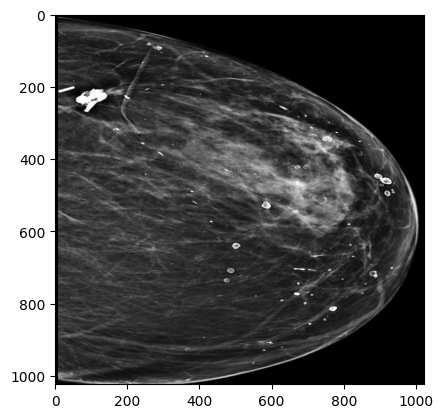

In [4]:
img_path = '/kaggle/input/grad-img/613462606.png'
def decode(path, img_size = (1024,1024)):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(file_bytes, channels=3)
    img = tf.image.resize(img, img_size)
    return img

img = decode(img_path)

plt.imshow(img/255)

img_array = np.expand_dims(np.asarray(img),axis=0)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap,  alpha=0.4):
    img = np.asarray(img)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    display(superimposed_img)

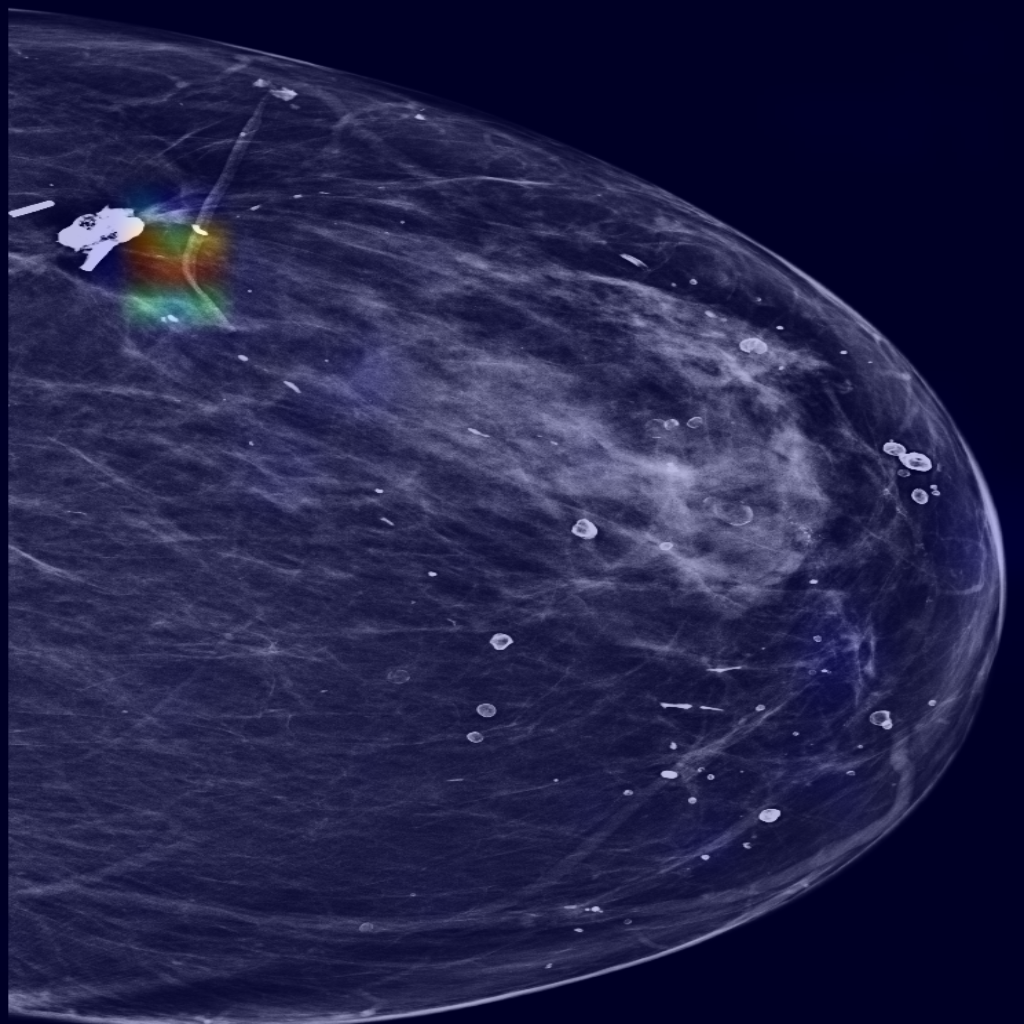

In [8]:
heatmap = make_gradcam_heatmap(img_array, model, 'conv5_block3_3_conv')
save_and_display_gradcam(img, heatmap,  alpha=0.4)

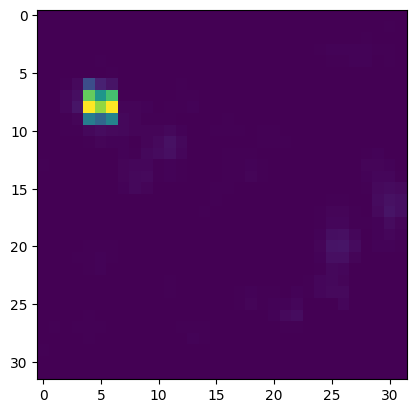

In [9]:
plt.imshow(heatmap)